In [45]:
import seaborn as sns
import os
import cv2
import random
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
base_dir = Path('../input/deepfake-image-detection/train-20250112T065955Z-001/train')
classes = ['real', 'fake']

filepaths = []
labels = []

for label in classes:
    class_dir = base_dir / label
    image_files = class_dir.glob('*')

    for file in image_files:
        if file.is_file():
            filepaths.append(str(file))
            labels.append(label)

In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')

In [5]:
df=pd.concat([Files,Label], axis=1)

In [7]:
df.sample(10)

,filepaths,labels
420,../input/deepfake-image-detection/train-202501...,fake
339,../input/deepfake-image-detection/train-202501...,fake
28,../input/deepfake-image-detection/train-202501...,real
367,../input/deepfake-image-detection/train-202501...,fake
459,../input/deepfake-image-detection/train-202501...,fake
166,../input/deepfake-image-detection/train-202501...,real
18,../input/deepfake-image-detection/train-202501...,real
133,../input/deepfake-image-detection/train-202501...,real
361,../input/deepfake-image-detection/train-202501...,fake
464,../input/deepfake-image-detection/train-202501...,fake


In [15]:
def sample_images(label, df, n=5):
    """
    Displays n images in a single row from the specified label.
    
    Parameters:
    - label (str): 'real' or 'fake'
    - df (pd.DataFrame): DataFrame with 'filepaths' and 'labels'
    - n (int): Number of images to display (default is 5)
    """
    subset = df[df['labels'] == label]
    
    if subset.empty:
        print(f"No images found with label: {label}")
        return

    sample_files = subset.sample(min(n, len(subset)))['filepaths'].tolist()

    plt.figure(figsize=(15, 5))
    for i, file_path in enumerate(sample_files):
        try:
            img = Image.open(file_path)
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label.capitalize()}")
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    plt.tight_layout()
    plt.show()

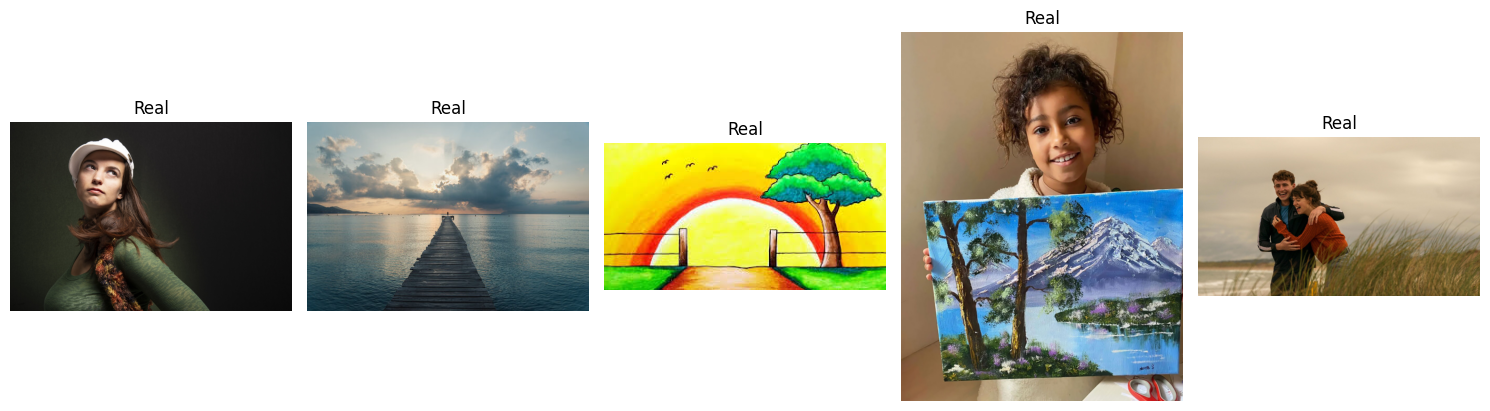

In [16]:
sample_images('real', df)

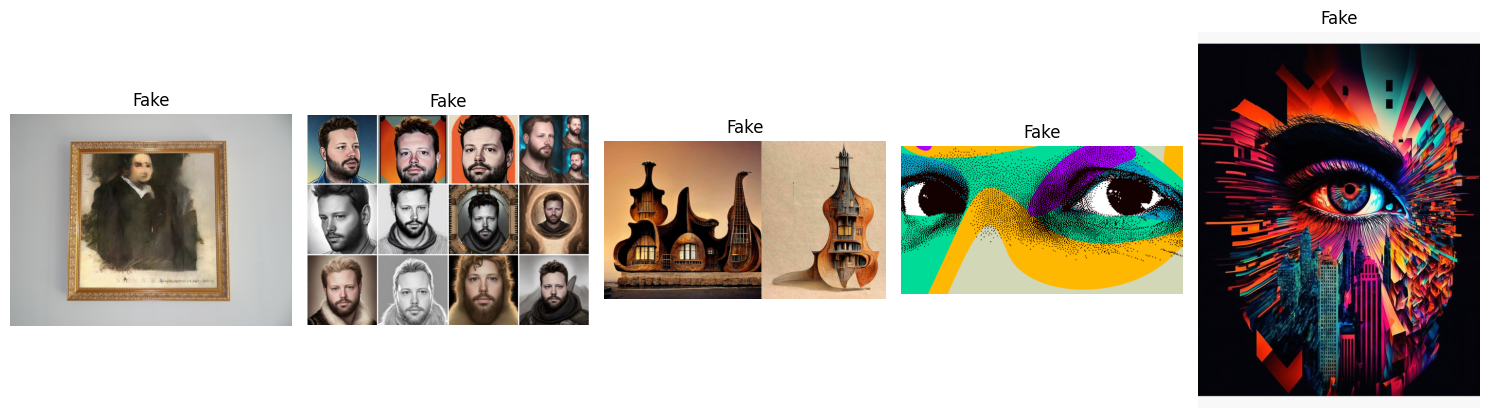

In [17]:
sample_images('fake', df)

In [18]:
def label_distribution(df):
    """
    Plots a bar chart and a pie chart showing the distribution of labels.
    Bar chart shows counts with text on top of bars.
    Pie chart shows percentages.
    """
    label_counts = df['labels'].value_counts()
    labels = label_counts.index
    counts = label_counts.values
    percentages = label_counts / label_counts.sum() * 100

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar plot
    axes[0].bar(labels, counts, color=['skyblue', 'salmon'])
    axes[0].set_title('Label Counts')
    axes[0].set_ylabel('Count')
    
    for i, count in enumerate(counts):
        axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

    axes[1].pie(
        counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'salmon']
    )
    axes[1].set_title('Label Distribution (%)')

    plt.tight_layout()
    plt.show()

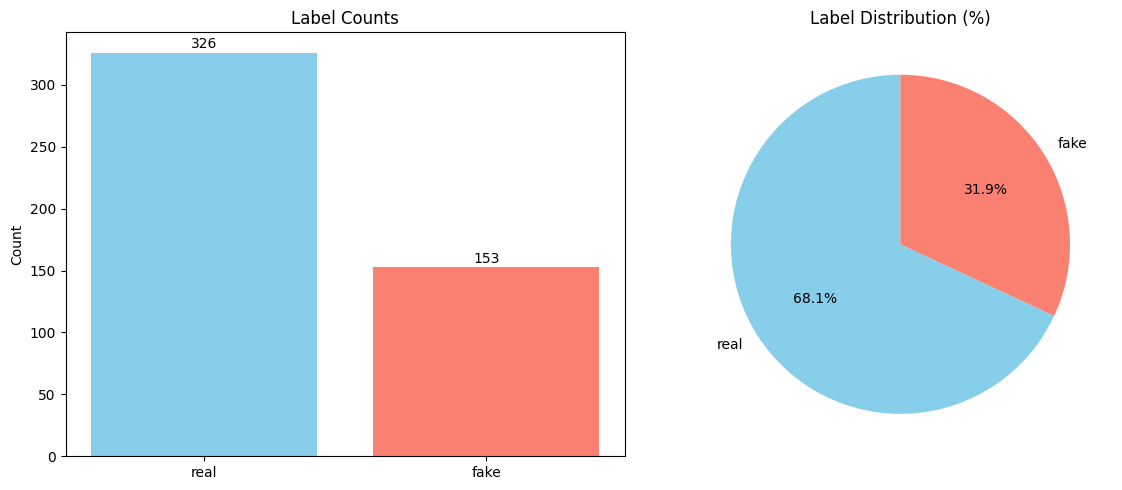

In [19]:
label_distribution(df)

In [25]:
path = '../input/deepfake-image-detection/train-20250112T065955Z-001/train/'

In [51]:
im_size = 225

images = []
labels = []


base_path = '../input/deepfake-image-detection/train-20250112T065955Z-001/train'
path = ['real', 'fake']

for label in path:
    data_path = os.path.join(base_path, label)
    filenames = os.listdir(data_path)

    for f in filenames:
        full_path = os.path.join(data_path, f)
        img = cv2.imread(full_path, 0)

        if img is not None:
            img = cv2.resize(img, (im_size, im_size))
            images.append(img)
            labels.append(label)
        else:
            print(f"Warning: Could not read image {full_path}")

libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


In [52]:
images[:1]

[array([[27, 26, 25, ..., 28, 27, 27],
        [27, 26, 25, ..., 28, 28, 27],
        [27, 26, 25, ..., 29, 28, 28],
        ...,
        [23, 23, 23, ..., 23, 23, 23],
        [23, 23, 23, ..., 23, 23, 23],
        [23, 23, 23, ..., 23, 23, 23]], dtype=uint8)]

In [53]:
labels[:5]

['real', 'real', 'real', 'real', 'real']

In [55]:
x = np.array(images).reshape((-1, 225, 225, 1))
x = x.astype('float32')/255.0

In [56]:
x.shape

(479, 225, 225, 1)

In [57]:
le = LabelEncoder()
y_encoded = le.fit_transform(labels) 
y = to_categorical(y_encoded, num_classes = 2)

In [58]:
y.shape

(479, 2)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, shuffle = True, random_state=42)

In [59]:
x_train.shape

(407, 225, 225, 1)

In [60]:
y_train.shape

(407, 2)

In [61]:
import tensorflow.keras
from tensorflow.keras import backend as K
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import Dropout,BatchNormalization,Input
from tensorflow.keras.losses import categorical_crossentropy


In [62]:
epochs = 10
input_shape = (225, 225, 1)

In [68]:
model= Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))

model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 225, 225, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 225, 225, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 225, 225, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 112, 112, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │     102,760,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,120,898 (393.38 MB)

 Trainable params: 103,118,978 (393.37 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [69]:
history = model.fit(x_train, y_train, epochs = epochs, validation_data=(x_test, y_test))

Epoch 1/10


I0000 00:00:1749144835.858030     134 service.cc:148] XLA service 0x7f00ac00d680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749144835.858793     134 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749144835.858823     134 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749144836.443523     134 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749144851.803340     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5297 - loss: 1.0719 - val_accuracy: 0.6944 - val_loss: 0.6498
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.7886 - loss: 0.4857 - val_accuracy: 0.6944 - val_loss: 0.6449
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8423 - loss: 0.3734 - val_accuracy: 0.6944 - val_loss: 0.6087
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9214 - loss: 0.2213 - val_accuracy: 0.6944 - val_loss: 0.6129
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8638 - loss: 0.3065 - val_accuracy: 0.6944 - val_loss: 0.6236
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9526 - loss: 0.1557 - val_accuracy: 0.6944 - val_loss: 0.6679
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9130 - loss: 0.1641 - val_accuracy: 0.6944 - val_loss: 0.7269
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9783 - loss: 0.0943 - val_accuracy: 0.6944 - val_lo